<>:11: SyntaxWarning: invalid escape sequence '\R'
<>:11: SyntaxWarning: invalid escape sequence '\R'
C:\Users\User\AppData\Local\Temp\ipykernel_19604\3504799638.py:11: SyntaxWarning: invalid escape sequence '\R'
  eeg_data_path = 'D:\Resume\AIMS Lab UIU\Given Assignments\Brain Computer Interface (BCI)/Data.xlsx'


Sampling Rate (Fs): 128.00 Hz


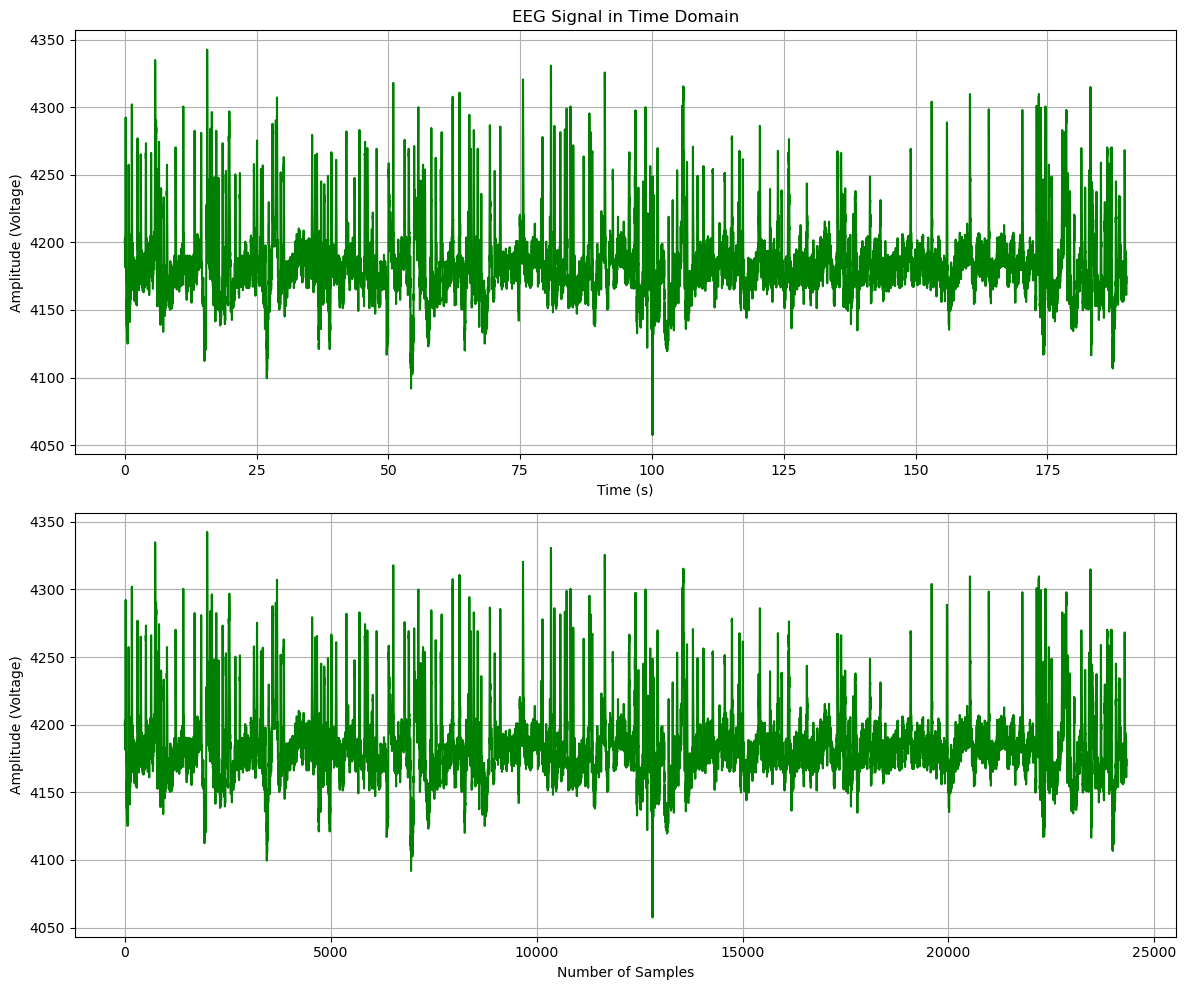

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import ttest_ind
import io
import math

# Loading the EEG data from the CSV file

eeg_data_path = 'D:\Resume\AIMS Lab UIU\Given Assignments\Brain Computer Interface (BCI)/Data.xlsx'
eeg_signal= pd.read_excel(eeg_data_path, sheet_name='Sheet1', header=None).iloc[:, 0].values

total_samples_data = len(eeg_signal)
total_time_seconds = 190

# Calculating the sampling rate (Hz) based on actual data length
fs = total_samples_data / total_time_seconds #sampling_rate
print(f"Sampling Rate (Fs): {fs:.2f} Hz")

# Generating the time vector
time = np.arange(0, total_samples_data) / fs

# Generating the sample index vector
sample_indices = np.arange(0, total_samples_data)

# Creating a figure with two subplots, arranged vertically (upside down implies one above the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Time in x-axis and amplitude in y-axis
axes[0].plot(time, eeg_signal, color = 'green')
axes[0].set_title('EEG Signal in Time Domain')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (Voltage)')
axes[0].grid(True)

# Plot 2: Number of samples in x-axis and amplitude in y-axis
axes[1].plot(sample_indices, eeg_signal, color = 'green')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Amplitude (Voltage)')
axes[1].grid(True)

plt.tight_layout()

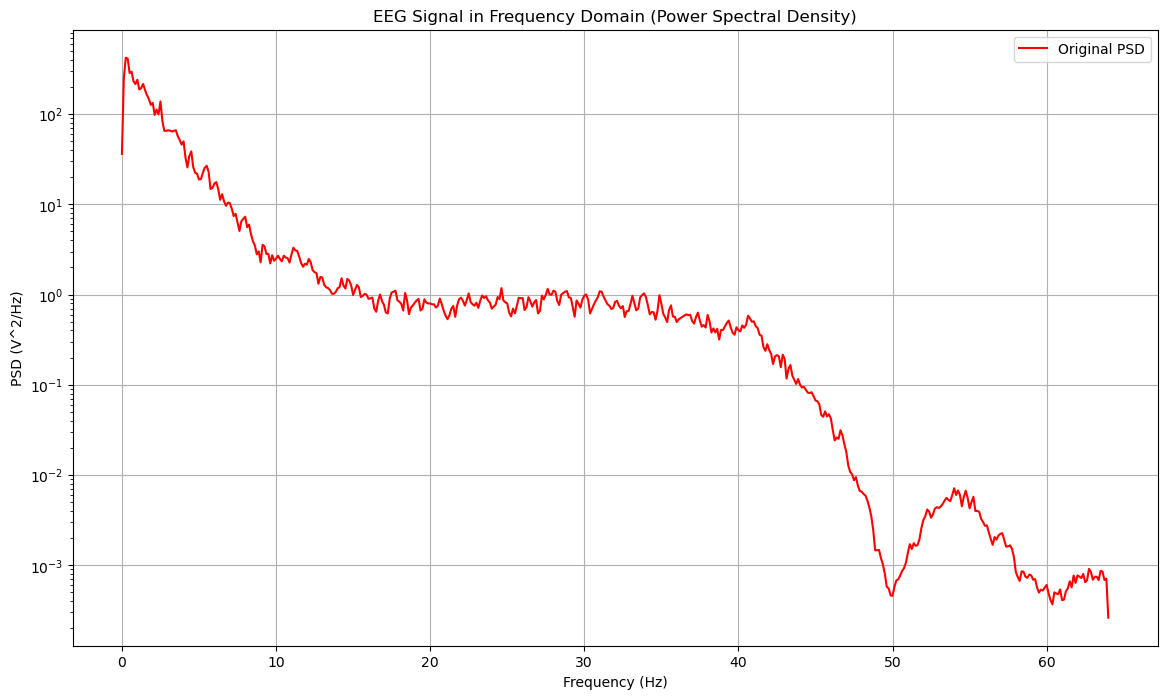

In [2]:
# Plotting EEG signal in the frequency domain using Welch’s method
freqs_orig, psd_orig = welch(eeg_signal, fs = fs, nperseg=1024)

plt.figure(figsize=(14, 8))
plt.semilogy(freqs_orig, psd_orig, label='Original PSD', color='red')
plt.title('EEG Signal in Frequency Domain (Power Spectral Density)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid(True)
plt.legend()
plt.show()

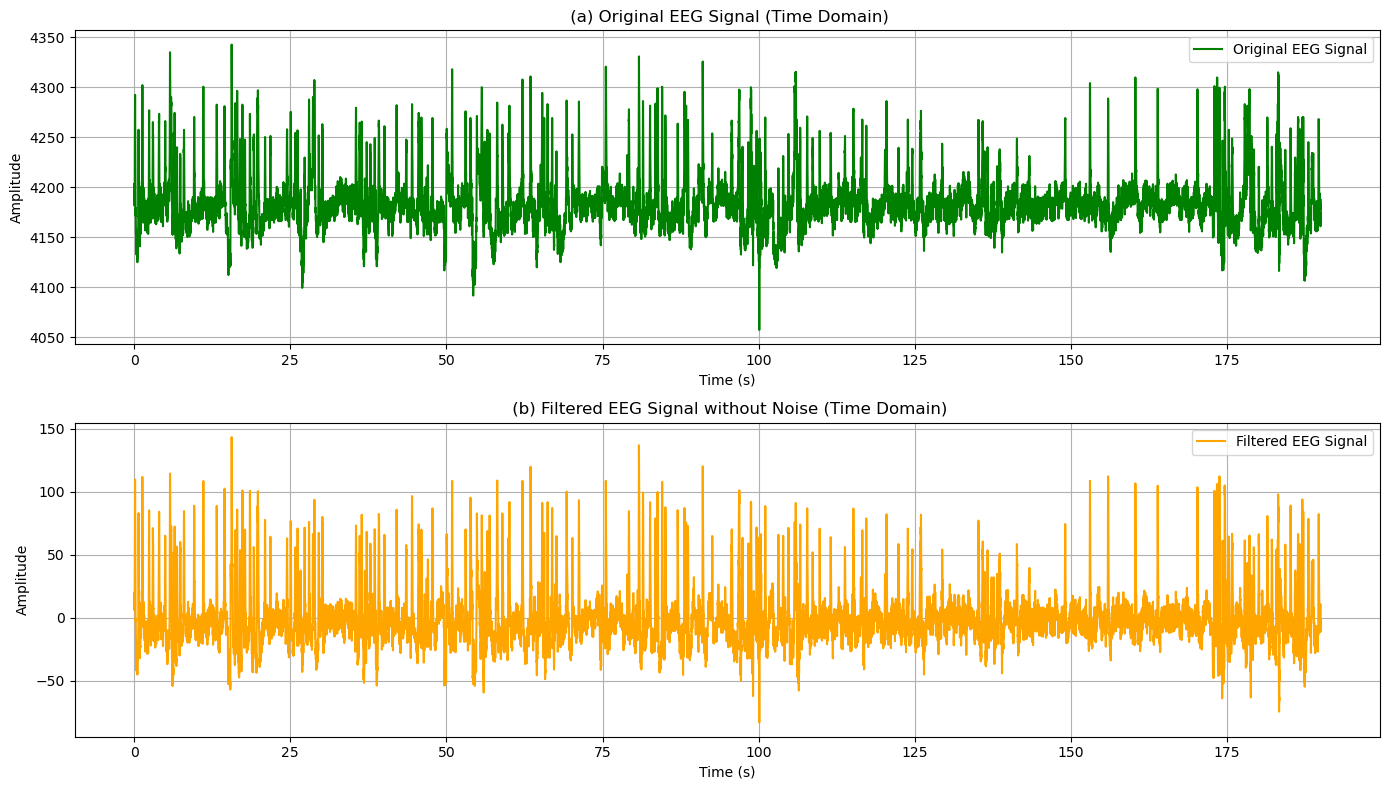

In [3]:
# --- Defining Filter Parameters ---
# Bandpass filter to keep frequencies between 0.5 Hz and 30 Hz
low_cutoff_bp = 0.5  # Hz (equivalent to high-pass cutoff)
high_cutoff_bp = 30  # Hz (equivalent to low-pass cutoff)

# Notch filter to remove power line interference (50 Hz for Bangladesh)
notch_freq = 50.0    # Hz

# --- Applying Filters ---

# 1. Bandpass filter
b_bp, a_bp = butter(4, [low_cutoff_bp / (0.5 * fs), high_cutoff_bp / (0.5 * fs)], btype='band')
eeg_signal_bp = filtfilt(b_bp, a_bp, eeg_signal)

# 2. Notch filter at 50 Hz
b_notch, a_notch = butter(2, [(notch_freq - 1) / (0.5 * fs), (notch_freq + 1) / (0.5 * fs)], btype='bandstop')
eeg_signal_filtered = filtfilt(b_notch, a_notch, eeg_signal_bp)


# --- Visualizing Results (Time Domain) ---
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(eeg_signal)) / fs, eeg_signal, label='Original EEG Signal', color='green')
plt.title(' (a) Original EEG Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(eeg_signal_filtered))/fs , eeg_signal_filtered, label='Filtered EEG Signal', color='orange')
plt.title(' (b) Filtered EEG Signal without Noise (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

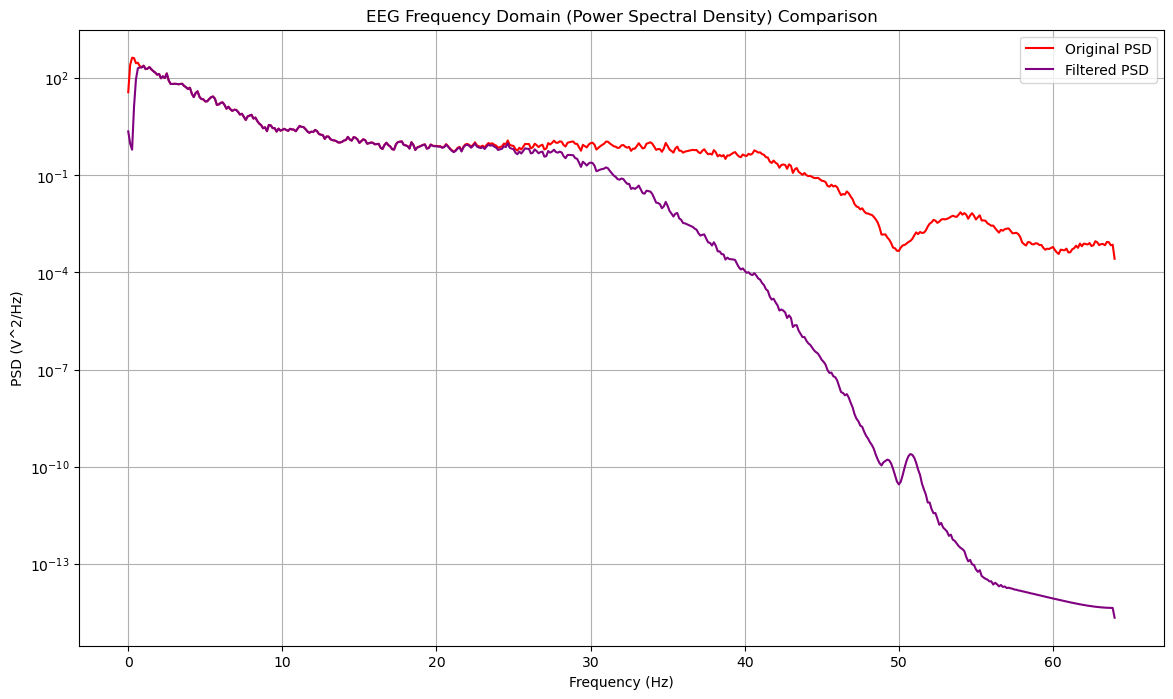

In [4]:
# --- Visualizing Results (Frequency Domain - PSD) ---
# Welch's method for PSD
freqs_filtered, psd_filtered = welch(eeg_signal_filtered, fs, nperseg=1024)

plt.figure(figsize=(14, 8))
plt.semilogy(freqs_orig, psd_orig, label='Original PSD', color='red')
plt.semilogy(freqs_filtered, psd_filtered, label='Filtered PSD', color='purple')
plt.title('EEG Frequency Domain (Power Spectral Density) Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid(True)
plt.legend()
plt.show()

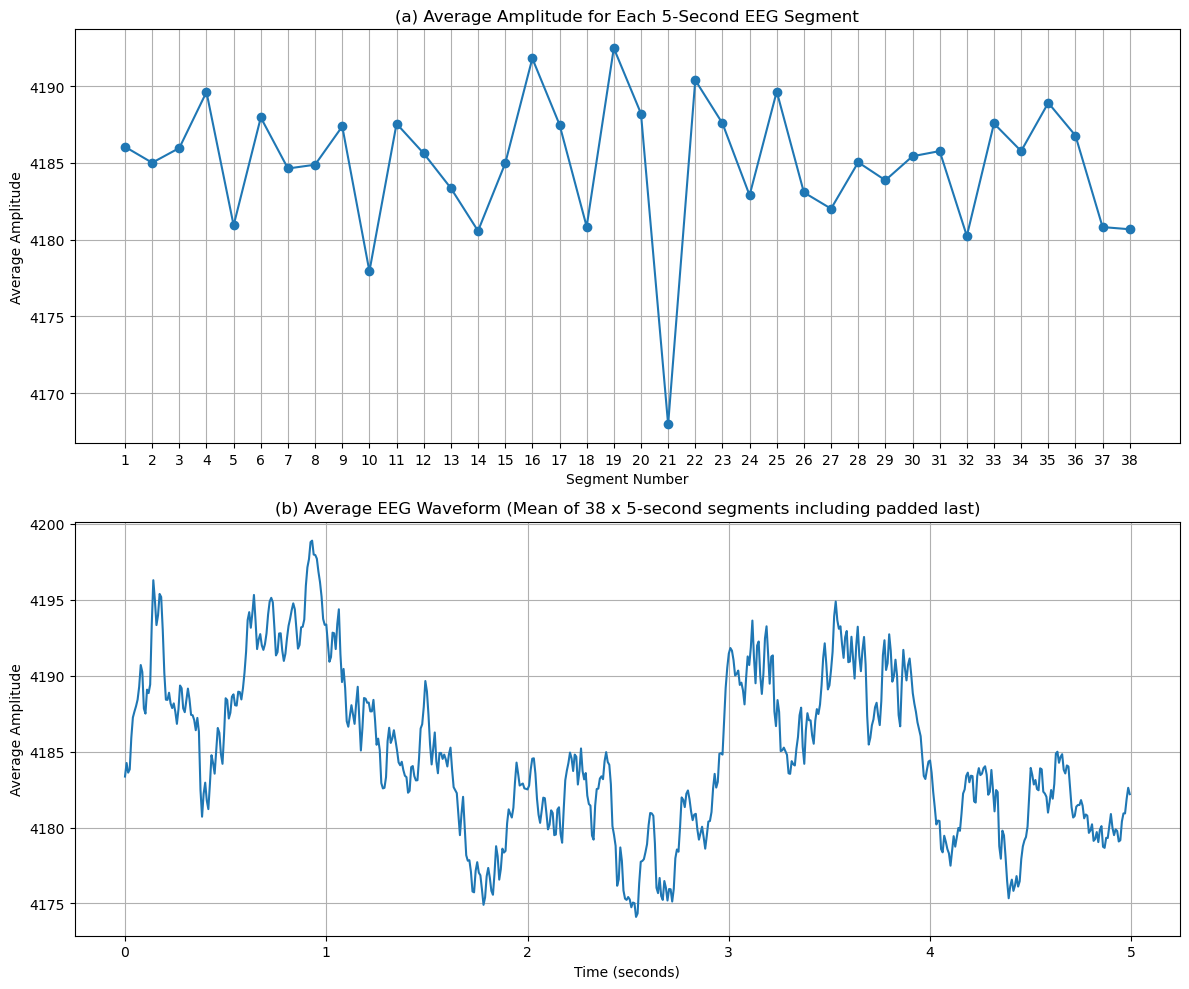

In [5]:
# Defining parameters
total_samples_data = len(eeg_signal)
total_time_seconds = 190
segment_duration_seconds = 5 # seconds

# Calculating the number of samples per segment
samples_per_segment = int(segment_duration_seconds * fs) # 5 * 128 = 640 samples

# Calculating the total number of segments, rounding up to include the last partial segment
num_segments = math.ceil(total_samples_data / samples_per_segment)

# --- Data for Plot 1 (Top): Average Amplitude for Each 5-Second Segment ---
average_amplitudes_per_segment = []
for i in range(num_segments):
    start_index = i * samples_per_segment
    end_index = min(start_index + samples_per_segment, total_samples_data)
    
    segment = eeg_signal[start_index:end_index]
    
    if len(segment) > 0:
        mean_amplitude = np.mean(segment)
        average_amplitudes_per_segment.append(mean_amplitude)
    else:
        average_amplitudes_per_segment.append(np.nan)

segment_numbers = np.arange(1, num_segments + 1)

# --- Data for Plot 2 (Bottom): Average Waveform of a Single 5-second Segment ---
segments = []
for i in range(num_segments):
    start_index = i * samples_per_segment
    end_index = start_index + samples_per_segment
    segment = eeg_signal[start_index:end_index]

    # Padding the segment with zeros if it's shorter than samples_per_segment
    if len(segment) < samples_per_segment:
        padded_segment = np.pad(segment, (0, samples_per_segment - len(segment)), 'constant', constant_values=0)
        segments.append(padded_segment)
    else:
        segments.append(segment)

segments_array = np.array(segments)
average_segment_waveform = np.mean(segments_array, axis=0)
time_average_segment = np.arange(0, samples_per_segment) / fs

# --- Plotting both types of graphs in the specified upside-down order ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False) # sharex=False as x-axes have different meanings

# Plot 1 (Top): Average Amplitude for Each 5-Second Segment
axes[0].plot(segment_numbers, average_amplitudes_per_segment, marker='o', linestyle='-')
axes[0].set_title('(a) Average Amplitude for Each 5-Second EEG Segment')
axes[0].set_xlabel('Segment Number')
axes[0].set_ylabel('Average Amplitude')
axes[0].set_xticks(segment_numbers) # Ensure all segment numbers are shown
axes[0].grid(True)

# Plot 2 (Bottom): Average Waveform of a Single 5-second Segment
axes[1].plot(time_average_segment, average_segment_waveform)
axes[1].set_title(f'(b) Average EEG Waveform (Mean of {num_segments} x {segment_duration_seconds}-second segments including padded last)')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Average Amplitude')
axes[1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels

In [7]:
# --- Hjorth Parameters Function ---
def hjorth_parameters(segment):
    if np.var(segment) == 0:
        return 0, 0, 0

    activity = np.var(segment)
    dx = np.diff(segment)
    if np.var(dx) == 0:
        return activity, 0, 0
    mobility = np.sqrt(np.var(dx) / activity)

    ddx = np.diff(dx)
    if np.var(ddx) == 0 or mobility == 0:
        return activity, mobility, 0
    complexity = np.sqrt(np.var(ddx) / np.var(dx)) / mobility
    return activity, mobility, complexity

# Store Hjorth parameters for all segments
all_activities = []
all_mobilities = []
all_complexities = []

segments = []
for i in range(num_segments):
    start_idx = i * samples_per_segment
    end_idx = start_idx + samples_per_segment
    segment = eeg_signal[start_idx:end_idx]
    activity, mobility, complexity = hjorth_parameters(segment)
    all_activities.append(activity)
    all_mobilities.append(mobility)
    all_complexities.append(complexity)


# --- Odd vs. Even Segments ---
odd_activities = [all_activities[i] for i in range(num_segments) if (i+1) % 2 != 0]
even_activities = [all_activities[i] for i in range(num_segments) if (i+1) % 2 == 0]

odd_mobilities = [all_mobilities[i] for i in range(num_segments) if (i+1) % 2 != 0]
even_mobilities = [all_mobilities[i] for i in range(num_segments) if (i+1) % 2 == 0]

odd_complexities = [all_complexities[i] for i in range(num_segments) if (i+1) % 2 != 0]
even_complexities = [all_complexities[i] for i in range(num_segments) if (i+1) % 2 == 0]

print("\n--- Hjorth Parameters Analysis ---")
print(f"Number of odd segments: {len(odd_activities)}")
print(f"Number of even segments: {len(even_activities)}")

print(f"List of odd activities:", odd_activities)
print(f"\n List of even activities:", even_activities)

print(f"\n List of odd mobilities:", odd_mobilities)
print(f"\n List of even mobilities:", even_mobilities)

print(f"\n List of odd complexities:", odd_complexities)
print(f"\n List of even complexities:", even_complexities)




--- Hjorth Parameters Analysis ---
Number of odd segments: 19
Number of even segments: 19
List of odd activities: [860.4503344558613, 529.0700409519377, 317.2907404844723, 183.3859659400892, 487.0741911276856, 1187.7799097163602, 973.3131653173936, 306.4950209732856, 1205.8650776820573, 438.33735910865045, 738.7149349147048, 216.08691756432063, 419.908482240759, 162.37593378598086, 182.38806300075228, 249.11248101059664, 491.5951380592646, 1131.1411716284172, 884.6639680300065]

 List of even activities: [1113.641707338425, 1964.5433875617186, 1262.1335531242607, 934.722801776715, 680.5157950510296, 1269.295931508444, 1056.8592278006727, 476.40784621925377, 872.6721397262663, 1229.0246980656248, 1082.3113786227236, 526.0593703546352, 432.3489625763629, 627.9988921158586, 174.89181239841318, 327.9425459479011, 78.54990304922238, 1330.3579522031318, 1089.2722736435971]

 List of odd mobilities: [0.26849830251264667, 0.27267340305779814, 0.3265014080189679, 0.40626113657015495, 0.2771967

In [8]:
# Performing T-tests
if len(odd_activities) > 1 and len(even_activities) > 1:
    t_activity, p_activity = ttest_ind(odd_activities, even_activities)
    t_mobility, p_mobility = ttest_ind(odd_mobilities, even_mobilities)
    t_complexity, p_complexity = ttest_ind(odd_complexities, even_complexities)
else:
    t_activity, p_activity = np.nan, np.nan
    t_mobility, p_mobility = np.nan, np.nan
    t_complexity, p_complexity = np.nan, np.nan
    print("Not enough odd/even segments for a valid t-test (at least 2 in each group needed).")

print(f"Paired t-test between odd and even segment's activity:", t_activity, p_activity)
print(f"Paired t-test between odd and even segment's mobility:", t_mobility, p_mobility)
print(f"Paired t-test between odd and even segment's complexity:", t_complexity, p_complexity)

Paired t-test between odd and even segment's activity: -2.1471710022796384 0.038587957336140684
Paired t-test between odd and even segment's mobility: 1.856398436944965 0.07159579777676184
Paired t-test between odd and even segment's complexity: -2.4094957870769145 0.021213463844342213


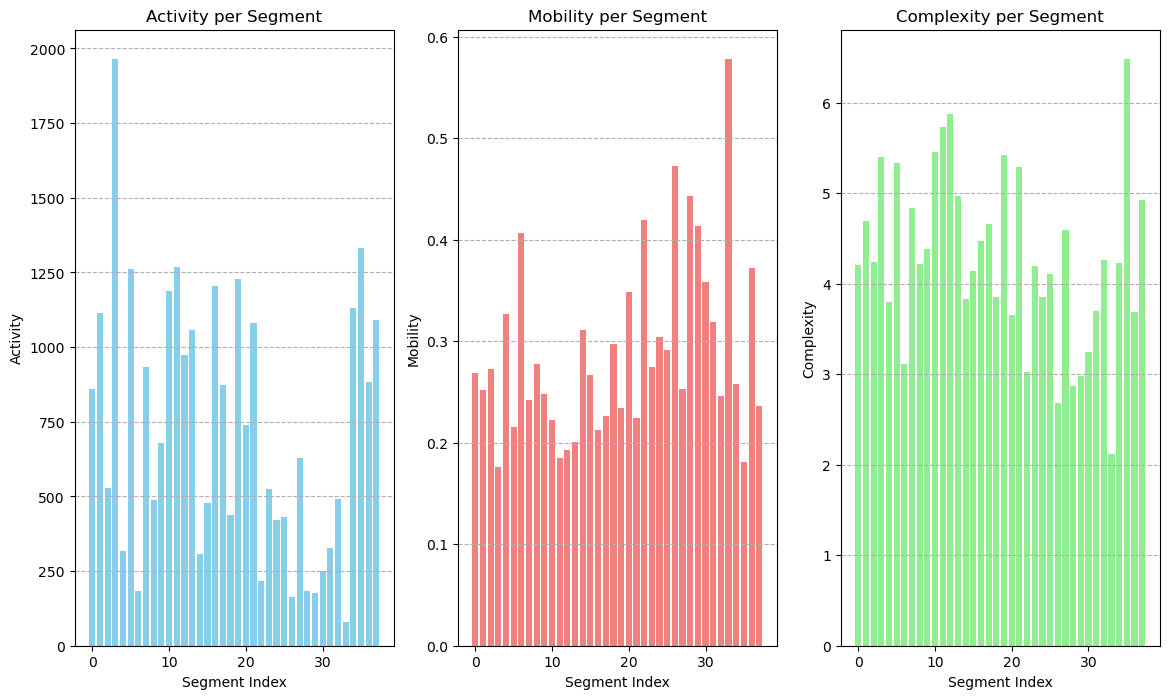

In [9]:
# --- Visualization: Hjorth Parameters for all segments ---
plt.figure(figsize=(14, 8))
plt.subplot(1, 3, 1)
plt.bar(range(num_segments), all_activities, color='skyblue')
plt.title('Activity per Segment')
plt.xlabel('Segment Index')
plt.ylabel('Activity')
plt.grid(axis='y', linestyle='--')

plt.subplot(1, 3, 2)
plt.bar(range(num_segments), all_mobilities, color='lightcoral')
plt.title('Mobility per Segment')
plt.xlabel('Segment Index')
plt.ylabel('Mobility')
plt.grid(axis='y', linestyle='--')

plt.subplot(1, 3, 3)
plt.bar(range(num_segments), all_complexities, color='lightgreen')
plt.title('Complexity per Segment')
plt.xlabel('Segment Index')
plt.ylabel('Complexity')
plt.grid(axis='y', linestyle='--')
plt.show()

=== HJORTH PARAMETERS ANOVA ANALYSIS (Sequential Groups) ===

Data Overview:
Shape: (38, 4)
Columns: [' Segment ', 'Activity ', 'Mobility ', 'Complexity ']

First few rows:
    Segment   Activity   Mobility   Complexity 
0          1   860.4503   0.268498     4.204849
1          2  1113.6420   0.251505     4.692283
2          3   529.0700   0.272673     4.242557
3          4  1964.5430   0.176090     5.403037
4          5   317.2907   0.326501     3.795483

Basic statistics:
        Segment     Activity   Mobility   Complexity 
count  38.000000    38.000000  38.000000    38.000000
mean   19.500000   723.542071   0.290186     4.276787
std    11.113055   440.438493   0.089811     0.960187
min     1.000000    78.549900   0.176090     2.117071
25%    10.250000   350.934000   0.228154     3.721157
50%    19.500000   654.257350   0.267528     4.221560
75%    28.750000  1087.531750   0.324564     4.903918
max    38.000000  1964.543000   0.578084     6.481535

Total segments: 38
Group structur

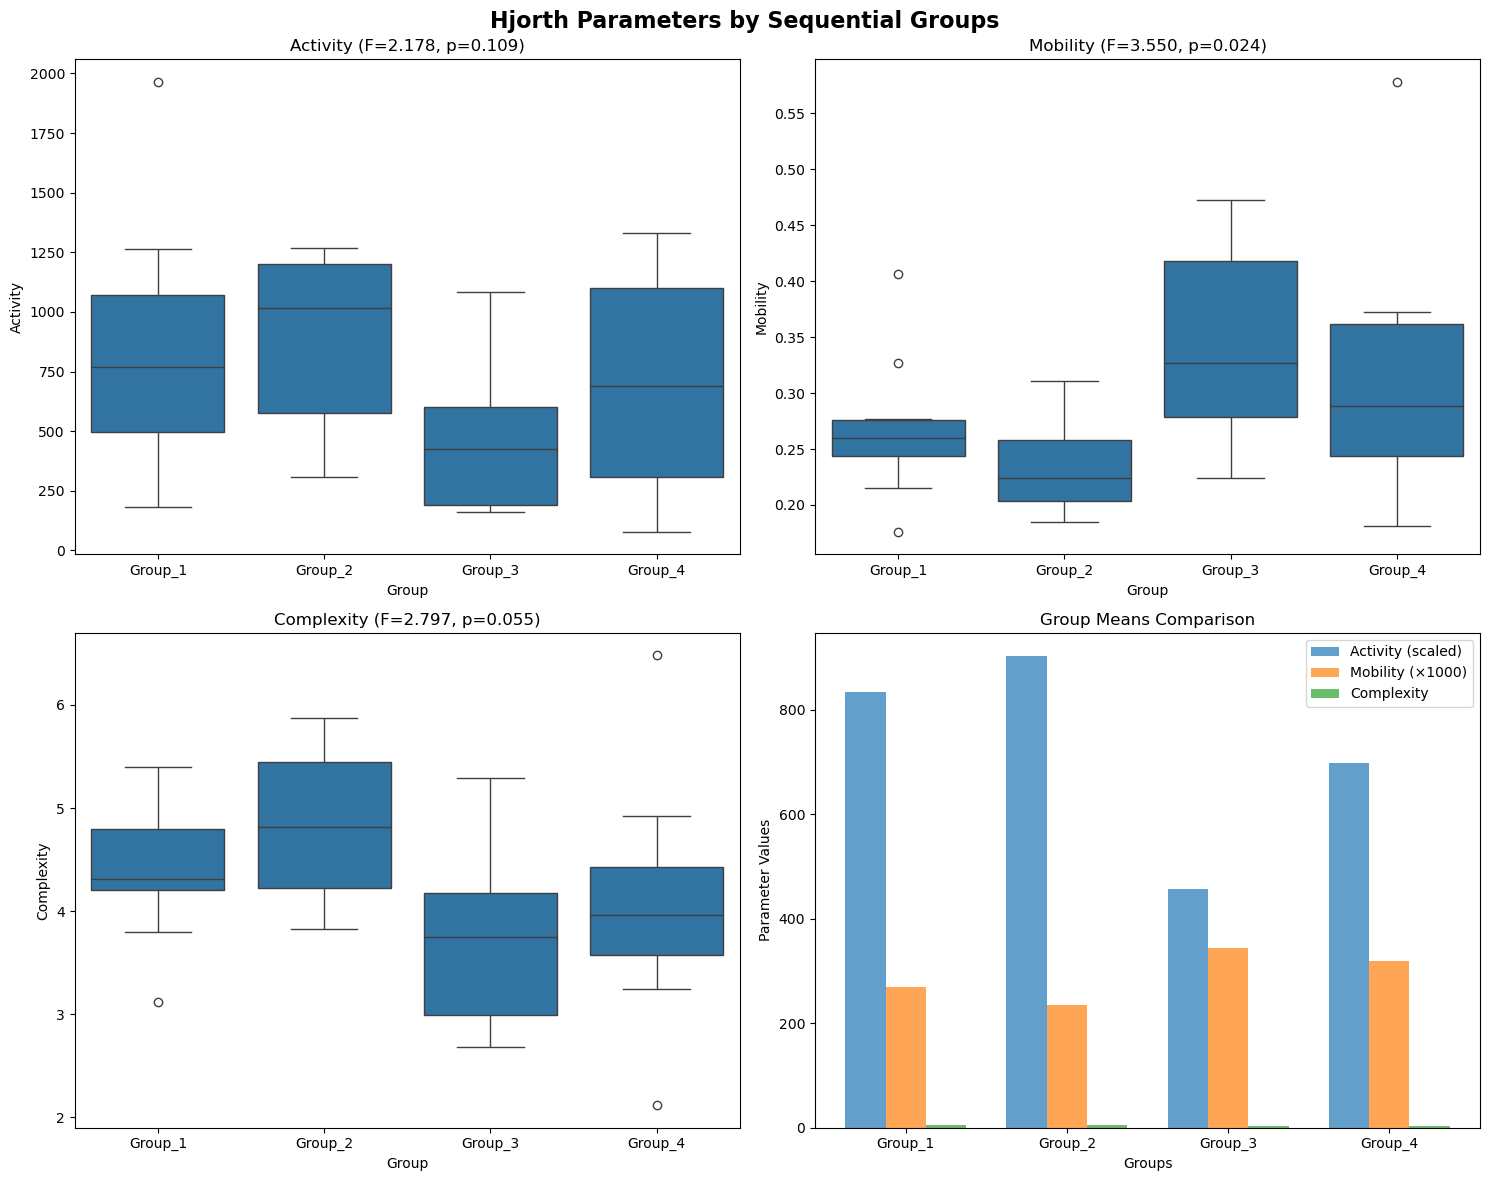


INTERPRETATION

Group Definitions:
- Group 1: Segments 1-10 (early recording period)
- Group 2: Segments 11-20 (early-mid recording period)
- Group 3: Segments 21-30 (mid-late recording period)
- Group 4: Segments 31-38 (late recording period)

Key Findings:
- Activity: not significant differences between groups
  (F = 2.178, p = 0.109, η² = 0.161 - large effect)
- Mobility: significant differences between groups
  (F = 3.550, p = 0.024, η² = 0.239 - large effect)
- Complexity: not significant differences between groups
  (F = 2.797, p = 0.055, η² = 0.198 - large effect)

This analysis suggests some temporal patterns in the EEG Hjorth parameters across the recording session.


In [11]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Read the Excel file
file_path = "D:\Resume\AIMS Lab UIU\Given Assignments\Brain Computer Interface (BCI)\Hjorth parameters of all 38 segments.xlsx"
df = pd.read_excel(file_path)

# Display basic information about the data
print("=== HJORTH PARAMETERS ANOVA ANALYSIS (Sequential Groups) ===\n")
print("Data Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

# Extract the three Hjorth parameters
activity = df.iloc[:, 1].values  # Activity column
mobility = df.iloc[:, 2].values  # Mobility column  
complexity = df.iloc[:, 3].values  # Complexity column

print(f"\nTotal segments: {len(activity)}")
print("Group structure: [10, 10, 10, 8] segments")

# Create sequential groups as specified
def create_sequential_groups(data):
    """Create four sequential groups from the data"""
    groups = {
        'Group_1': data[0:10],    # Segments 1-10
        'Group_2': data[10:20],   # Segments 11-20
        'Group_3': data[20:30],   # Segments 21-30
        'Group_4': data[30:38]    # Segments 31-38 (8 segments)
    }
    return groups

# Create groups for each parameter
activity_groups = create_sequential_groups(activity)
mobility_groups = create_sequential_groups(mobility)
complexity_groups = create_sequential_groups(complexity)

print("\n=== GROUP COMPOSITION ===")
for i, (group_name, group_data) in enumerate(activity_groups.items(), 1):
    segment_range = f"1-10" if i == 1 else f"{(i-1)*10+1}-{i*10}" if i < 4 else "31-38"
    print(f"{group_name} (Segments {segment_range}): n = {len(group_data)}")

# Function to perform detailed ANOVA analysis
def perform_anova_analysis(groups_dict, parameter_name):
    """Perform comprehensive ANOVA analysis"""
    print(f"\n=== {parameter_name.upper()} PARAMETER ANALYSIS ===")
    
    # Extract group data
    group_data = list(groups_dict.values())
    group_names = list(groups_dict.keys())
    
    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(*group_data)
    
    # Calculate descriptive statistics for each group
    print("\nDescriptive Statistics by Group:")
    group_stats = []
    for i, (name, data) in enumerate(groups_dict.items()):
        mean_val = np.mean(data)
        std_val = np.std(data, ddof=1)  # Sample standard deviation
        n_val = len(data)
        group_stats.append({
            'Group': name,
            'N': n_val,
            'Mean': mean_val,
            'Std': std_val,
            'Min': np.min(data),
            'Max': np.max(data)
        })
        print(f"  {name}: Mean = {mean_val:.4f} ± {std_val:.4f}, n = {n_val}")
    
    # Calculate effect size (eta-squared)
    # First, we need to calculate sum of squares
    all_data = np.concatenate(group_data)
    grand_mean = np.mean(all_data)
    
    # Sum of squares between groups (SSB)
    ssb = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in group_data)
    
    # Sum of squares within groups (SSW)
    ssw = sum(sum((x - np.mean(group))**2 for x in group) for group in group_data)
    
    # Total sum of squares (SST)
    sst = sum((x - grand_mean)**2 for x in all_data)
    
    # Effect size (eta-squared)
    eta_squared = ssb / sst
    
    # Degrees of freedom
    df_between = len(group_data) - 1
    df_within = len(all_data) - len(group_data)
    
    # Mean squares
    ms_between = ssb / df_between
    ms_within = ssw / df_within
    
    print(f"\nANOVA Results:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {df_between} between, {df_within} within")
    print(f"  Effect size (η²): {eta_squared:.4f} ({eta_squared*100:.2f}%)")
    
    # Interpret significance
    alpha = 0.05
    if p_value < alpha:
        print(f"  Result: SIGNIFICANT (p < {alpha})")
        
        # Perform post-hoc analysis (Tukey's HSD) if significant
        print(f"\n  Post-hoc Analysis (Tukey's HSD):")
        
        # Prepare data for post-hoc test
        all_values = []
        all_groups = []
        for group_name, group_data in groups_dict.items():
            all_values.extend(group_data)
            all_groups.extend([group_name] * len(group_data))
        
        tukey = pairwise_tukeyhsd(endog=all_values, groups=all_groups, alpha=alpha)
        print(tukey)
        
    else:
        print(f"  Result: NOT SIGNIFICANT (p ≥ {alpha})")
    
    print(f"\n  ANOVA Table:")
    print(f"    Source          SS        df       MS        F      p-value")
    print(f"    Between    {ssb:10.4f}     {df_between}   {ms_between:10.4f}  {f_stat:7.4f}  {p_value:.6f}")
    print(f"    Within     {ssw:10.4f}    {df_within}   {ms_within:10.4f}")
    print(f"    Total      {sst:10.4f}    {df_between + df_within}")
    
    return {
        'f_statistic': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'group_stats': group_stats
    }

# Perform ANOVA for each parameter
print("\n" + "="*60)
print("DETAILED ANOVA ANALYSIS")
print("="*60)

activity_results = perform_anova_analysis(activity_groups, "Activity")
mobility_results = perform_anova_analysis(mobility_groups, "Mobility")
complexity_results = perform_anova_analysis(complexity_groups, "Complexity")

# Summary table
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)

summary_data = {
    'Parameter': ['Activity', 'Mobility', 'Complexity'],
    'F-statistic': [activity_results['f_statistic'], 
                   mobility_results['f_statistic'], 
                   complexity_results['f_statistic']],
    'p-value': [activity_results['p_value'], 
               mobility_results['p_value'], 
               complexity_results['p_value']],
    'Effect Size (η²)': [activity_results['eta_squared'], 
                        mobility_results['eta_squared'], 
                        complexity_results['eta_squared']],
    'Significant': [activity_results['p_value'] < 0.05,
                   mobility_results['p_value'] < 0.05,
                   complexity_results['p_value'] < 0.05]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hjorth Parameters by Sequential Groups', fontsize=16, fontweight='bold')

# Activity boxplot
activity_plot_data = []
activity_plot_groups = []
for group_name, group_data in activity_groups.items():
    activity_plot_data.extend(group_data)
    activity_plot_groups.extend([group_name] * len(group_data))

df_activity = pd.DataFrame({'Value': activity_plot_data, 'Group': activity_plot_groups})
sns.boxplot(data=df_activity, x='Group', y='Value', ax=axes[0,0])
axes[0,0].set_title(f'Activity (F={activity_results["f_statistic"]:.3f}, p={activity_results["p_value"]:.3f})')
axes[0,0].set_ylabel('Activity')

# Mobility boxplot
mobility_plot_data = []
mobility_plot_groups = []
for group_name, group_data in mobility_groups.items():
    mobility_plot_data.extend(group_data)
    mobility_plot_groups.extend([group_name] * len(group_data))

df_mobility = pd.DataFrame({'Value': mobility_plot_data, 'Group': mobility_plot_groups})
sns.boxplot(data=df_mobility, x='Group', y='Value', ax=axes[0,1])
axes[0,1].set_title(f'Mobility (F={mobility_results["f_statistic"]:.3f}, p={mobility_results["p_value"]:.3f})')
axes[0,1].set_ylabel('Mobility')

# Complexity boxplot
complexity_plot_data = []
complexity_plot_groups = []
for group_name, group_data in complexity_groups.items():
    complexity_plot_data.extend(group_data)
    complexity_plot_groups.extend([group_name] * len(group_data))

df_complexity = pd.DataFrame({'Value': complexity_plot_data, 'Group': complexity_plot_groups})
sns.boxplot(data=df_complexity, x='Group', y='Value', ax=axes[1,0])
axes[1,0].set_title(f'Complexity (F={complexity_results["f_statistic"]:.3f}, p={complexity_results["p_value"]:.3f})')
axes[1,0].set_ylabel('Complexity')

# Group means comparison
group_names = ['Group_1', 'Group_2', 'Group_3', 'Group_4']
activity_means = [np.mean(activity_groups[g]) for g in group_names]
mobility_means = [np.mean(mobility_groups[g]) for g in group_names]
complexity_means = [np.mean(complexity_groups[g]) for g in group_names]

x = np.arange(len(group_names))
width = 0.25

axes[1,1].bar(x - width, activity_means, width, label='Activity (scaled)', alpha=0.7)
axes[1,1].bar(x, [m*1000 for m in mobility_means], width, label='Mobility (×1000)', alpha=0.7)
axes[1,1].bar(x + width, complexity_means, width, label='Complexity', alpha=0.7)

axes[1,1].set_xlabel('Groups')
axes[1,1].set_ylabel('Parameter Values')
axes[1,1].set_title('Group Means Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(group_names)
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Final interpretation
print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("\nGroup Definitions:")
print("- Group 1: Segments 1-10 (early recording period)")
print("- Group 2: Segments 11-20 (early-mid recording period)")
print("- Group 3: Segments 21-30 (mid-late recording period)")
print("- Group 4: Segments 31-38 (late recording period)")

print("\nKey Findings:")
for param, results in [('Activity', activity_results), 
                      ('Mobility', mobility_results), 
                      ('Complexity', complexity_results)]:
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    effect_size = "large" if results['eta_squared'] > 0.14 else "medium" if results['eta_squared'] > 0.06 else "small"
    
    print(f"- {param}: {significance} differences between groups")
    print(f"  (F = {results['f_statistic']:.3f}, p = {results['p_value']:.3f}, η² = {results['eta_squared']:.3f} - {effect_size} effect)")

print(f"\nThis analysis suggests {'some' if any(r['p_value'] < 0.05 for r in [activity_results, mobility_results, complexity_results]) else 'no'} temporal patterns in the EEG Hjorth parameters across the recording session.")